In [1]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
from pprint import pprint

/home/julian/Projects/MasterThesis/Pilot Decoder/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mlflow.set_tracking_uri("sqlite:///mlruns.db")

client = MlflowClient()

experiments = client.search_experiments()

exp_df = pd.DataFrame(
    [
        {
            "experiment_id": e.experiment_id,
            "name": e.name,
            "lifecycle_stage": e.lifecycle_stage,
            "artifact_location": e.artifact_location,
        }
        for e in experiments
    ]
)

exp_df.sort_values("name")



2026/02/03 12:36:43 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/03 12:36:43 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/03 12:36:43 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/03 12:36:43 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/03 12:36:43 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/03 12:36:43 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/03 12:36:43 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/03 12:36:43 INFO alembic.runtime.migration: Will assume non-transactional DDL.


,experiment_id,name,lifecycle_stage,artifact_location
1,0,Default,active,/home/julian/Projects/MasterThesis/Pilot Decod...
0,1,grid-representations,active,/home/julian/Projects/MasterThesis/Pilot Decod...


In [3]:
EXPERIMENT_NAME = "grid-representations"

experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
experiment_id = experiment.experiment_id

experiment


<Experiment: artifact_location='/home/julian/Projects/MasterThesis/Pilot Decoder/mlruns/1', creation_time=1770104346161, experiment_id='1', last_update_time=1770104346161, lifecycle_stage='active', name='grid-representations', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [4]:
runs_df = mlflow.search_runs(
    experiment_ids=[experiment_id],
    order_by=["attributes.start_time DESC"],
)

runs_df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.k0/train_loss,metrics.k0/md_90_mean,metrics.k0/sm_60_max,metrics.k0/sm_90_mean,...,metrics.k1/norm,metrics.k1/lambda_norm,metrics.k1/val_loss,metrics.k1/lambda_pos,metrics.k1/separation,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.source.git.commit
0,efe704bf094f4d1ea9cc64efc67c5666,1,FINISHED,/home/julian/Projects/MasterThesis/Pilot Decod...,2026-02-03 09:59:47.461000+00:00,2026-02-03 10:07:41.787000+00:00,0.410899,0.134486,0.437836,0.085718,...,NaN,NaN,NaN,NaN,NaN,wistful-dolphin-946,julian,train.py,LOCAL,0ec6404f8ef8c076e4a8b09eaa010c3ab0afc1ae
1,d4959fd903d7443a9a6400eff9e7aa6e,1,FAILED,/home/julian/Projects/MasterThesis/Pilot Decod...,2026-02-03 09:49:01.816000+00:00,2026-02-03 09:55:07.950000+00:00,0.027526,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,honorable-cub-780,julian,train.py,LOCAL,0ec6404f8ef8c076e4a8b09eaa010c3ab0afc1ae
2,136028e51baa470d95ace9deb121b8f0,1,FINISHED,/home/julian/Projects/MasterThesis/Pilot Decod...,2026-02-03 08:55:58.368000+00:00,2026-02-03 09:47:47.254000+00:00,0.006220,0.226436,0.437630,0.163072,...,NaN,NaN,NaN,NaN,NaN,capable-quail-828,julian,train.py,LOCAL,0ec6404f8ef8c076e4a8b09eaa010c3ab0afc1ae
3,9001d42d6e794e049df35c2894d6f8ab,1,FINISHED,/home/julian/Projects/MasterThesis/Pilot Decod...,2026-02-03 08:40:51.454000+00:00,2026-02-03 08:47:13.187000+00:00,0.006774,0.258093,0.746293,0.120011,...,NaN,NaN,NaN,NaN,NaN,rare-rook-710,julian,train.py,LOCAL,0ec6404f8ef8c076e4a8b09eaa010c3ab0afc1ae
4,e13b7eac5e21446faa827d2a05150461,1,FAILED,/home/julian/Projects/MasterThesis/Pilot Decod...,2026-02-03 08:36:06.878000+00:00,2026-02-03 08:40:32.931000+00:00,0.008996,0.274324,0.928754,0.431104,...,0.013734,0.004145,0.023314,0.175533,0.008285,hilarious-eel-338,julian,train.py,LOCAL,0ec6404f8ef8c076e4a8b09eaa010c3ab0afc1ae


In [5]:
RUN_ID = "efe704bf094f4d1ea9cc64efc67c5666"
run = client.get_run(RUN_ID)

print("Run info:")
pprint(run.info)

print("\nParams:")
pprint(run.data.params)

print("\nMetrics:")
pprint(run.data.metrics)

print("\nTags:")
pprint(run.data.tags)


Run info:
<RunInfo: artifact_uri=('/home/julian/Projects/MasterThesis/Pilot '
 'Decoder/mlruns/1/efe704bf094f4d1ea9cc64efc67c5666/artifacts'), end_time=1770113261787, experiment_id='1', lifecycle_stage='active', run_id='efe704bf094f4d1ea9cc64efc67c5666', run_name='wistful-dolphin-946', start_time=1770112787461, status='FINISHED', user_id='julian'>

Params:
{}

Metrics:
{'k0/lambda_norm': 7.148730562968703e-05,
 'k0/lambda_pos': 794.0719634023504,
 'k0/lg_60_max': 0.829799109833079,
 'k0/lg_60_mean': 0.19264514163967872,
 'k0/lg_90_max': 0.9106230761506181,
 'k0/lg_90_mean': 0.18145525608842758,
 'k0/md_60_max': 0.7959561651104485,
 'k0/md_60_mean': 0.10596569719446106,
 'k0/md_90_max': 0.8179110815978669,
 'k0/md_90_mean': 0.13448569243356168,
 'k0/norm': 0.11150519214570523,
 'k0/norm_geco': -0.30674530241165426,
 'k0/positivity': 0.00011888177468790672,
 'k0/positivity_geco': -0.19593650848614,
 'k0/separation': 0.3163718581199646,
 'k0/sm_60_max': 0.4378364684297532,
 'k0/sm_60_mean

In [6]:
import torch
from omegaconf import OmegaConf
import hydra
from rgm import ActionableRGM

k = 0

# Load config.yaml
config_path = client.download_artifacts(
    run_id=RUN_ID,
    path="config.yaml"  # or the directory
)

cfg = OmegaConf.load(config_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = hydra.utils.instantiate(cfg.model).to(device)

state_dict_path = client.download_artifacts(
    run_id=RUN_ID,
    path=f"models/model_k{k}_state_dict.pt"
)

state_dict = torch.load(state_dict_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

ActionableRGM()

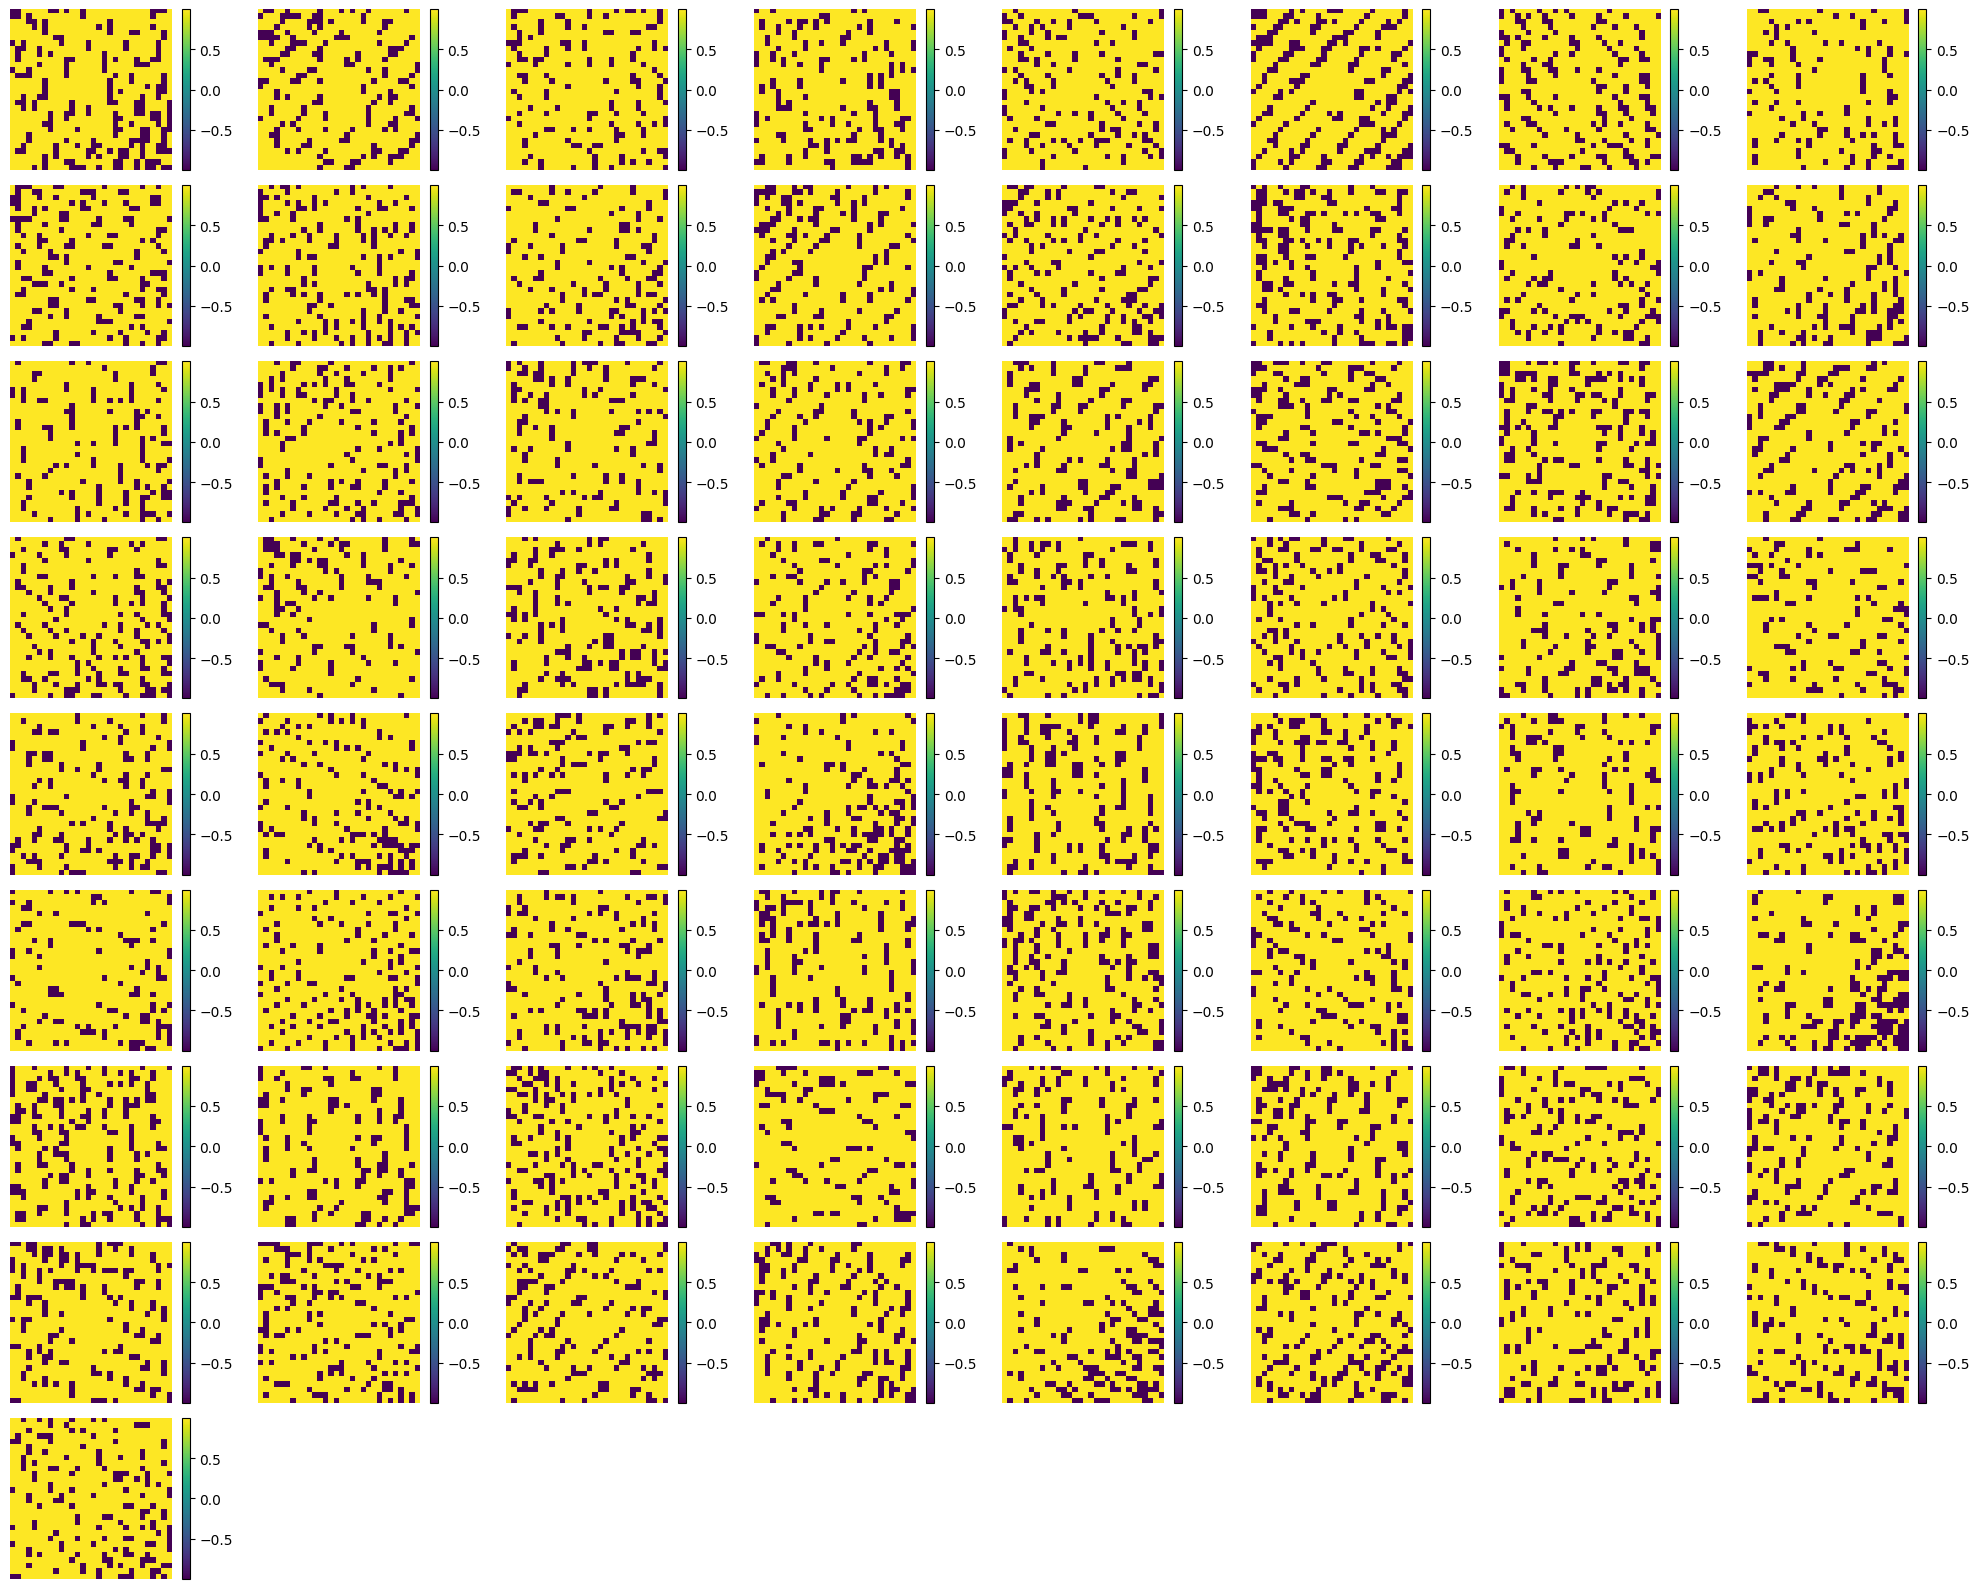

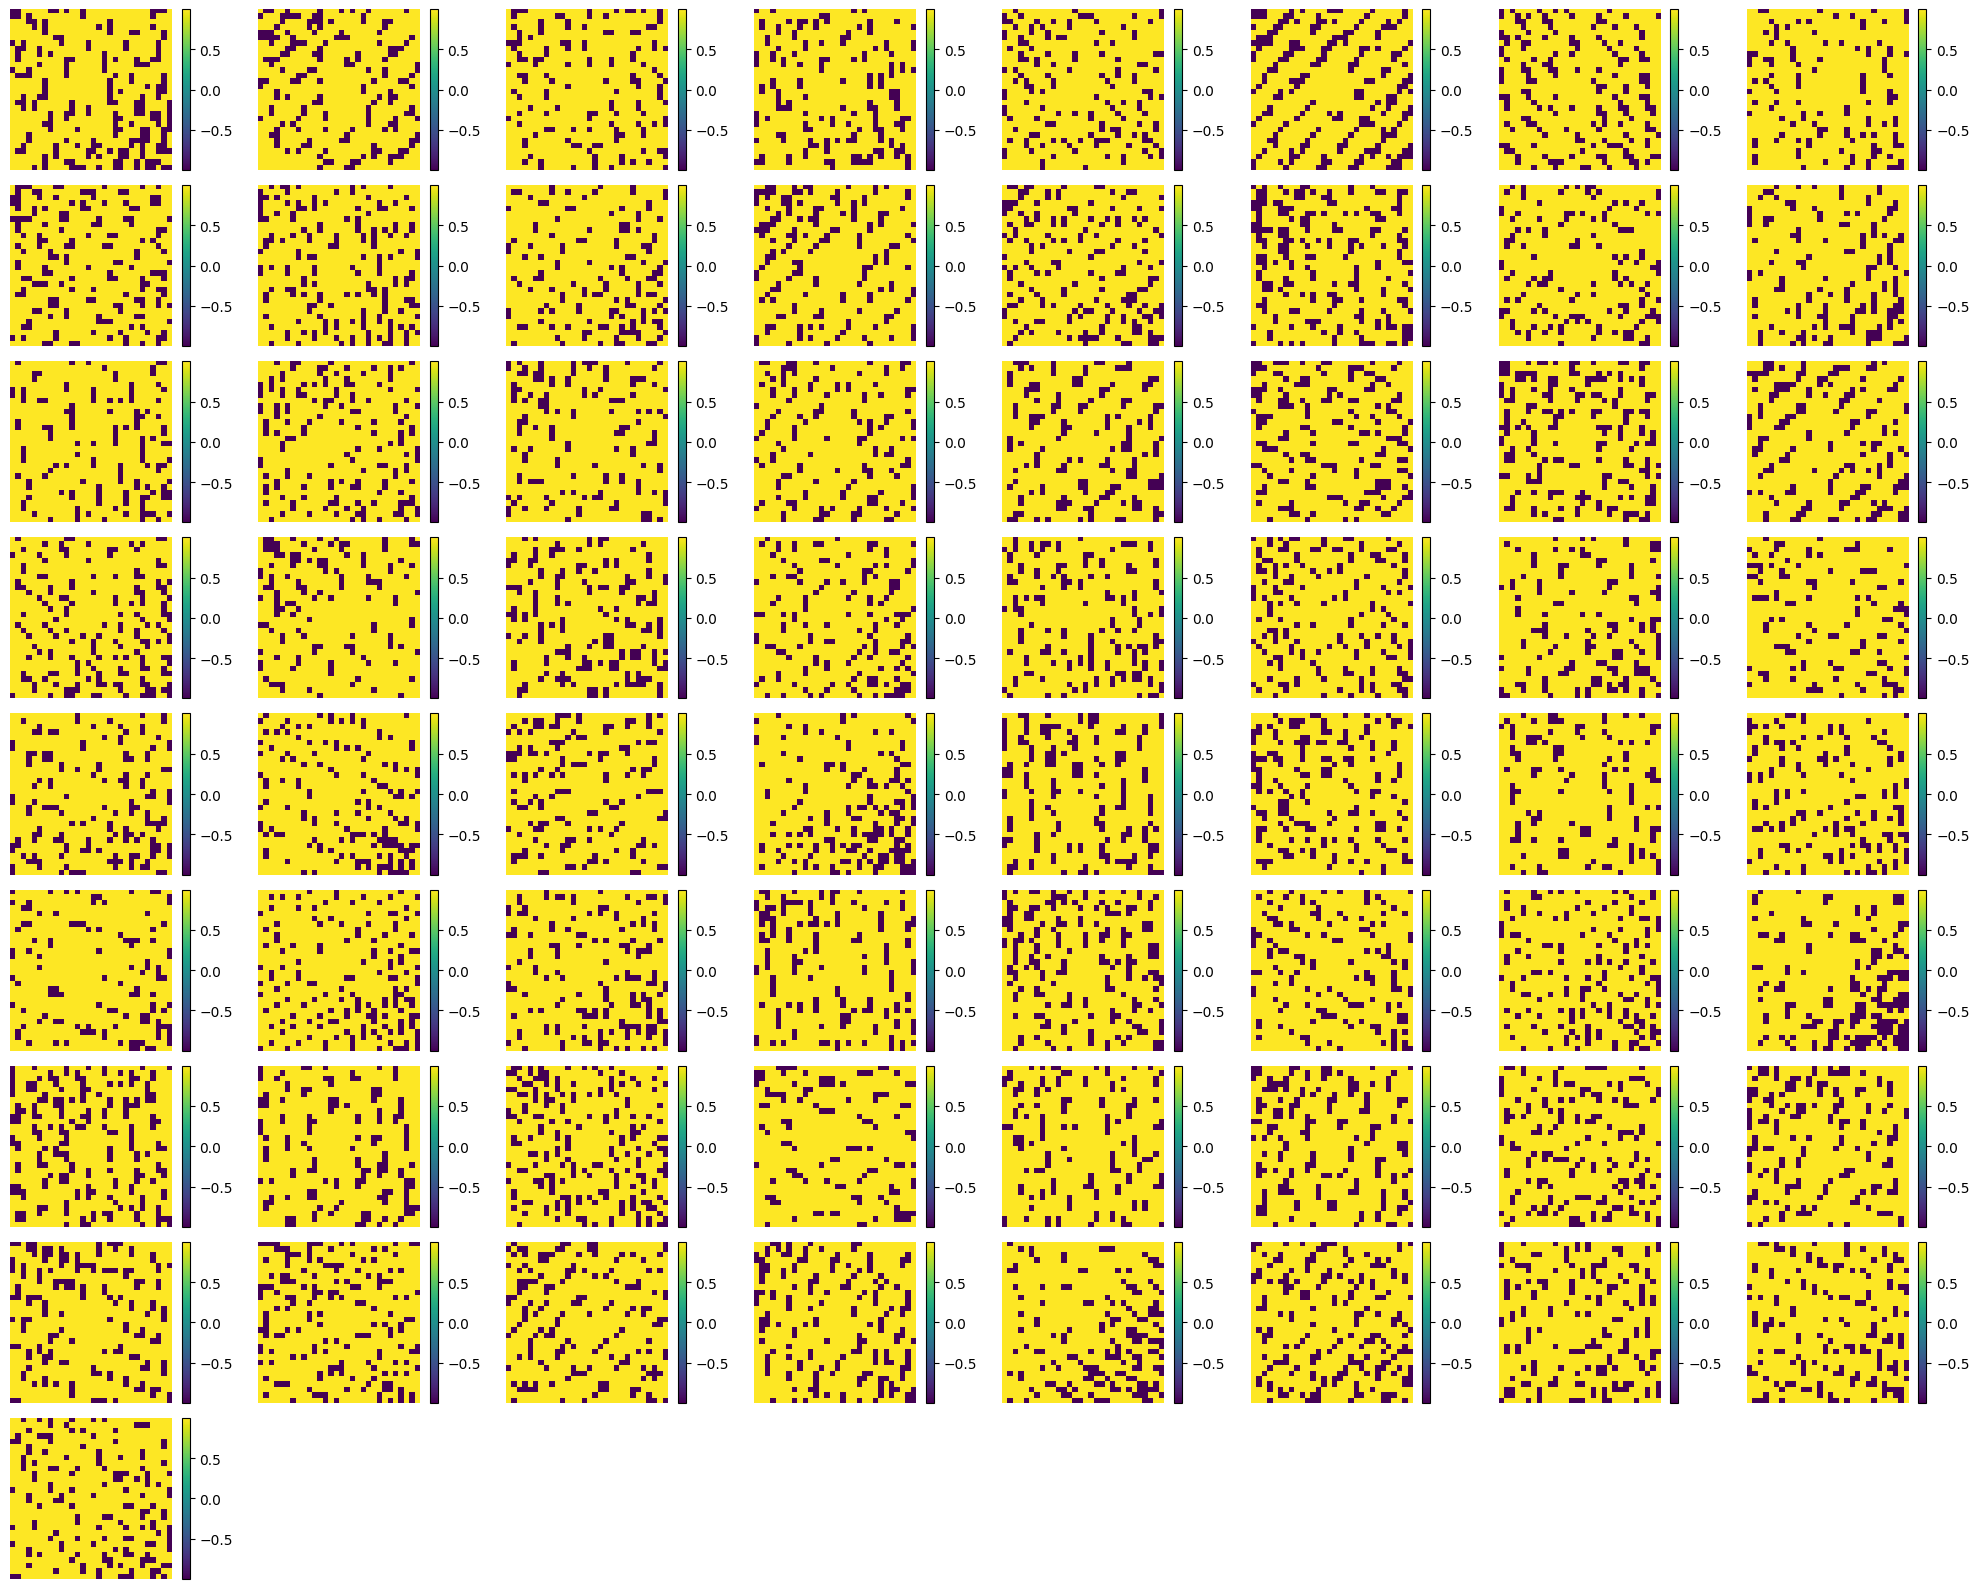

In [7]:
from analysis import generate_2d_plots, create_loss_plots_from_mlflow, neuron_plotter_2d, get_ratemaps
torch.set_float32_matmul_precision('high')

maps = get_ratemaps(model, res = 30, widths=tuple([10]))
neuron_plotter_2d(maps[0], 30)
# res, fig = generate_2d_plots(model, k)
# fig